# Mode fitting

Here we will make a simple hierarchical model that encodes some knowledge of quasi-equally spaced modes of oscillation into the prior.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

Let's set up the data first.  We will define a bunch of Lorentzian modes that are nearly equaly space in frequency.  The mode heights will be controlled by a Gaussian function. 

So the mode frequencies will be defined as:

$f_{n, {\rm true}} = (n + 0.5) \Delta \nu + \mathcal{N}(0, 0.02)$.

and the envelope will just be:

$H_n = 25.0 \exp(-0.5 (f_{n, {\rm true}} - \nu_{\rm max})^2 / 5^2)$

The data are then just the model of the sum of the Lorentzians, evaluated a frequencies $f_{i}$, plus 1.  To the data we add Gaussian noise (to keep things simple) with mean zero and standard deviation of unity.

Text(0.5,0,'Frequnency')

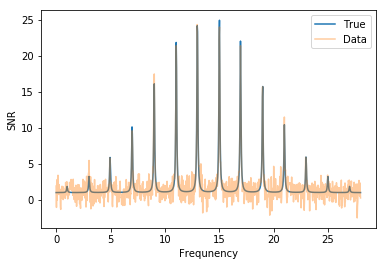

In [200]:
def lor(f, f0, w, h):
    return h / (1.0 + 4.0 * ((f - f0)/w)**2)

def gaussian(f, f0, h, w):
    return h * np.exp(-0.5 * (f - f0)**2 / w**2)

np.random.seed(53)
f = np.linspace(0, 28, 1000)
dnu = 2.0
numax = 14.0
f0s = (np.arange(0, 14, 1) + 0.5) * dnu 
f0s += + np.random.randn(len(f0s)) * 0.02
true = np.ones(len(f))
true += np.sum([lor(f, n, 0.1, gaussian(n, numax, 25.0, 5.0)) for n in f0s], axis=0)
#data = true * np.random.chisquare(2, len(true)) / 2.0
data = true + np.random.randn(len(true))
fig, ax = plt.subplots()
ax.plot(f, true, label='True', zorder=0)
ax.plot(f, data, label='Data', alpha=0.4)
ax.legend()
ax.set_ylabel('SNR')
ax.set_xlabel('Frequnency')

We now transform the data into a ladder, or echelle, with one mode in each segment.

In [184]:
bin_width = f[1] - f[0]
w = int(dnu / bin_width)
s = 0
h = int(np.floor(len(data[s:]) / w))
ladder_p = np.reshape(data[s:h*w+s], [h, w])
ladder_f = np.reshape(f[s:h*w+s], [h, w])

We can collapse the echelle and combine with some smoothing techniques to show you the data:

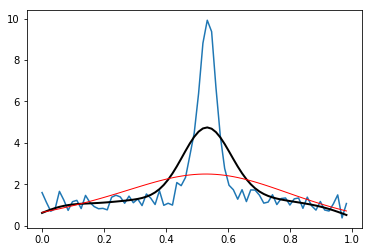

In [201]:
from astropy.convolution import Gaussian1DKernel, convolve
fig, ax = plt.subplots()
ax.plot(ladder_f[0,:] / dnu, np.mean(ladder_p, axis=0))
# Create kernel
g = Gaussian1DKernel(stddev=5)
# Convolve data
z = convolve(np.mean(ladder_p, axis=0), g)
ax.plot(ladder_f[0,:] / dnu, z, 'k-', lw=2)
# Create kernel
g = Gaussian1DKernel(stddev=15)
# Convolve data
z = convolve(np.mean(ladder_p, axis=0), g)
ax.plot(ladder_f[0,:] / dnu, z, 'r-', lw=1)

In [202]:
n_max = numax / dnu
nn = 14
d_f = ladder_f[0,:] / dnu

Now we can plot the uncollapsed echelle:

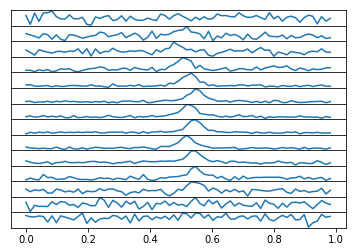

In [204]:
fig, ax = plt.subplots(nn)
for i in range(int(nn)):
        ax[i].plot(d_f, ladder_p[i,:], label=f'Index: {i}')
        ax[i].set_yticks([])        
plt.subplots_adjust(hspace=0.0, wspace=0.0)

And now we build the example Pystan model:

In [157]:
code = '''
functions {
    real lor(real freq, real f0, real w, real h){
        return h / (1 + 4 * ((freq - f0)/w)^2);
    }
    real gaussian(real f, real numax, real width, real height){
        return height * exp(-0.5 * (f - numax)^2 / width^2);
    }
}
data {
    int N; // Data points per order
    int M; // Number of orders
    real freq[M, N];
    real snr[M, N];
    real dnu_est;
    real numax_est;
}
parameters {
    real<lower = 0> dnu;
    real<lower = 0> numax;
    real<lower = 0> envwidth;
    real<lower = 0> envheight;
    real modewidth;
    real delta[M];
    real<lower = 0> scale;
}
transformed parameters {
    real mode_freqs[M];
    real mode_heights[M];
    for (i in 1:M){
        mode_freqs[i] = (i-0.5) * dnu + delta[i] * scale;
        mode_heights[i] = gaussian(mode_freqs[i], numax, envwidth, envheight);
    }
}
model {
    real beta[N];
    for (i in 1:M){
        for (j in 1:N){
            beta[j] =  (1.0 + lor(freq[i, j], mode_freqs[i], modewidth, mode_heights[i]));
        }
        snr[i, :] ~ normal(beta, 1.0);
    }
    dnu ~ normal(dnu_est, dnu_est * 0.01);
    dnu ~ uniform(dnu_est * 0.9, dnu_est * 1.1);
    numax ~ normal(numax_est, numax_est * 0.01);
    numax ~ uniform(numax_est * 0.9, numax_est * 1.1);
    envwidth ~ normal(5.0, 1.0);
    envheight ~ normal(25.0, 3.0);
    modewidth ~ lognormal(log(0.1), 0.05);
    modewidth ~ uniform(0, 0.5);
    delta ~ normal(0, 1); 
    scale ~ normal(0, 0.01);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ae1e6452f5130395d3f50a4387192288 NOW.


The code takes a while to converge.  We run for 20000 iterations and check the results.

In [188]:
stan_data = {'N': len(ladder_f[0,:]), 'M': len(ladder_p[:,0]), 
             'freq': ladder_f, 'snr': ladder_p,
            'dnu_est': dnu, 'numax_est': numax}
nchains = 4
start = {'dnu': dnu, 'numax': numax}
fitsm = sm.sampling(data=stan_data, iter=20000, chains=nchains, init=[start for n in range(nchains)])

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


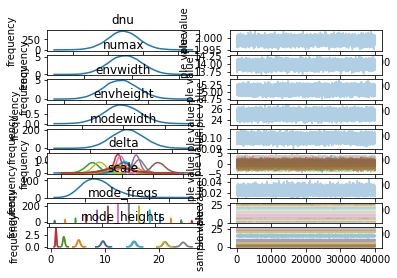

In [189]:
fitsm.plot()
plt.show()

In [190]:
print(fitsm)

Inference for Stan model: anon_model_ae1e6452f5130395d3f50a4387192288.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu                 2.0  9.9e-6 9.1e-4    2.0    2.0    2.0    2.0    2.0   8355    nan
numax             13.97  3.5e-4   0.07  13.84  13.92  13.97  14.02  14.11  40000    1.0
envwidth           5.07  4.1e-4   0.08   4.91   5.01   5.07   5.13   5.23  40000    1.0
envheight         24.97  2.5e-3   0.43  24.13  24.68  24.97  25.26  25.81  29869    1.0
modewidth           0.1  1.0e-5 2.0e-3    0.1    0.1    0.1    0.1    0.1  37423    1.0
delta[0]          -0.36  4.3e-3   0.85   -2.0  -0.92  -0.37   0.19   1.37  40000    1.0
delta[1]           0.43  2.8e-3   0.57  -0.73   0.07   0.45   0.81   1.51  40000    1.0
delta[2]           -2.0  3.1e-3   0.44  -2.93  -2.29  -1.99   -1.7  -1.18  21163    1.0
delta[3]       

The convergence is good! (The nan Rhat is because the dnu value is so well constrained).  We can check the inferred frequencies with respect to the true frequencies:

(40000, 14)
(14,)


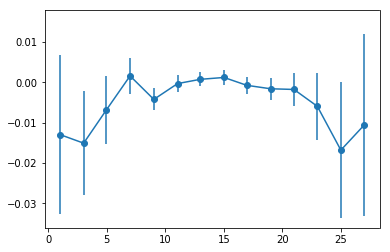

In [191]:
fig, ax = plt.subplots()
ax.scatter(f0s, fitsm['mode_freqs'].mean(axis=0) - f0s)
ax.errorbar(f0s, fitsm['mode_freqs'].mean(axis=0) - f0s, yerr=fitsm['mode_freqs'].std(axis=0))
print(fitsm['mode_freqs'].shape)
print(f0s.shape)

Here is a corner plot of the results:

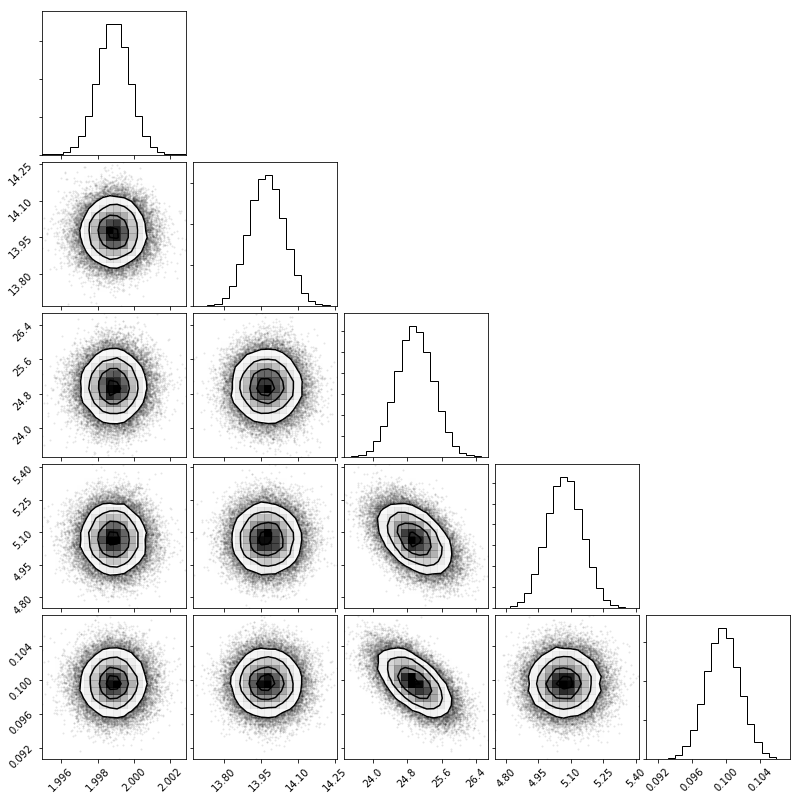

In [205]:
import corner
post = np.vstack([fitsm['dnu'], fitsm['numax'], fitsm['envheight'], fitsm['envwidth'], fitsm['modewidth']]).T
corner.corner(post)
plt.show()

We can now compare the true model with the estimated model:

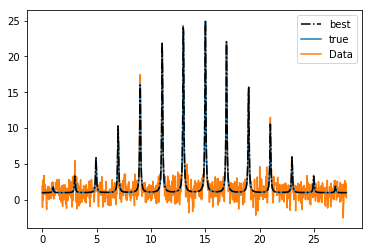

In [198]:
best = np.ones(len(f))
best += np.sum([lor(f, n, fitsm['modewidth'].mean(), gaussian(n, fitsm['numax'].mean(),
                            fitsm['envheight'].mean(), fitsm['envwidth'].mean())
                   ) for n in fitsm['mode_freqs'].mean(axis=0)], axis=0)
plt.plot(f, best, 'k-.', label='best', zorder=99)
plt.plot(f, true, label='true', zorder=98)
plt.plot(f, data, label='Data')
plt.legend()

This model works pretty well although things take a long time to converge.  Hopefully for the real data, good informative priors on the general mode properties will help convergence.

Note we will also have to use the proper chi squared two degrees of freedom noise of the real periodogram!